### Importing the Libraries

In [2]:

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle


In [3]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [40]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 16
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 512

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Loading the dataset

In [5]:
dataset = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
dataset

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
sentiment_map = {0:'NEGATIVE',2:'NEUTRAL',4:'POSITIVE'}
def decode_sentiment(label):
    return sentiment_map[int(label)]

In [7]:
dataset.target = dataset.target.apply(lambda x: decode_sentiment(x))

In [8]:
dataset

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Data pre-processing and EDA

<BarContainer object of 2 artists>

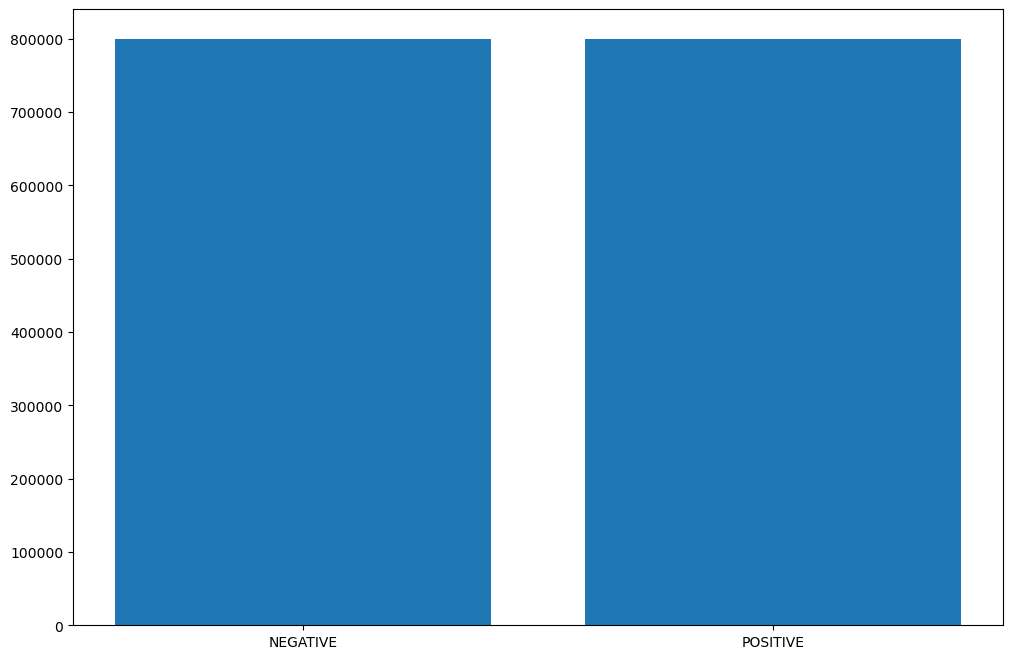

In [9]:
target_count = Counter(dataset.target)

plt.figure(figsize=(12,8))
plt.bar(target_count.keys(),target_count.values())

balanced dataset

In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

removing stop words and stemming process

In [11]:
def preprocess_data(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE," ",str(text).lower()).strip()
    tokens=[]
    
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
        

In [12]:
%%time
dataset.text = dataset.text.apply(lambda x: preprocess_data(x))

CPU times: user 25.7 s, sys: 64.5 ms, total: 25.8 s
Wall time: 25.8 s


In [13]:
dataset

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see
...,...,...,...,...,...,...
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feeling ever
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb com cool hear old walt interviews
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask details
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday boo alll time tupac amaru ...


In [14]:
dataset_train, dataset_test = train_test_split(dataset,test_size=1-TRAIN_SIZE,random_state=42)

In [15]:
print("Trainig data size",len(dataset_train))
print("Test data size",len(dataset_test))

Trainig data size 1280000
Test data size 320000


Word2Vec

In [16]:
documents = [_text.split() for _text in dataset_train.text]

In [30]:
w2v = gensim.models.word2vec.Word2Vec(
                                      window=W2V_WINDOW,
                                     min_count=W2V_MIN_COUNT,
                                     workers=8)

In [18]:
w2v.build_vocab(documents)

In [19]:
words = w2v.wv.key_to_index.keys()
vocab_size = len(words)
print("vocab size", vocab_size)

vocab size 30369


In [20]:
%%time
w2v.train(documents, total_examples=len(documents),epochs=W2V_EPOCH)

CPU times: user 9min 47s, sys: 2.72 s, total: 9min 50s
Wall time: 2min 20s


(263125629, 295270528)

Tokoenize text

In [21]:
%%time
tokenizer = Tokenizer()

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 13.4 µs


In [22]:
tokenizer.fit_on_texts(dataset_train.text)

vocab_size = len(tokenizer.word_index)+1
print("total words",vocab_size)

total words 290419


In [23]:
%%time 
x_train = pad_sequences(tokenizer.texts_to_sequences(dataset_train.text),maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(dataset_test.text),maxlen=SEQUENCE_LENGTH)

CPU times: user 15.2 s, sys: 298 ms, total: 15.5 s
Wall time: 15.6 s


Label Encoding

In [24]:
labels = dataset_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [25]:
encoder = LabelEncoder()
encoder.fit(dataset_train.target.tolist())

y_train = encoder.transform(dataset_train.target.to_list())
y_test = encoder.transform(dataset_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [26]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [27]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

Adding Embedding layer

In [31]:
embedding_matrix = np.zeros((vocab_size,W2V_SIZE))
for word,i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i]=w2v.mv[word]
print(embedding_matrix.shape)

(290419, 300)


In [32]:
embedding_layer = Embedding(vocab_size, W2V_SIZE,
                            weights=[embedding_matrix], 
                            input_length=SEQUENCE_LENGTH, 
                            trainable=False)

### Model Building

In [42]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(50,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout_3 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                70200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 87195951 (332.63 MB)
Trainable params: 70251 (274.42 KB)
Non-trainable params: 87125700 (332.36 MB)
_________________________________________________________________


Compile model

In [43]:
model.compile(loss='binary_crossentropy',optimizer='adam',
             metrics=['accuracy'])

In [44]:
callbacks = [ReduceLROnPlateau(monitor='val_loss',patience=5,cooldown=0),
            EarlyStopping(monitor='val_acc',min_delta=1e-4,patience=5)]

### Training model

In [46]:
history = model.fit(x_train,y_train,
                   batch_size=BATCH_SIZE,
                   epochs=2,
                   validation_split=0.15,
                   verbose=1,
                   callbacks = callbacks)

Epoch 1/2


2023-10-05 20:05:02.277325: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1305600000 exceeds 10% of free system memory.


  30/2125 [..............................] - ETA: 30:46 - loss: 0.6932 - accuracy: 0.5018

KeyboardInterrupt: 